## Calibrating Tour Mode Choice
This script will iteratively perform updates to the tour mode choice coefficients config file in order to match model outputs to calibration targets.

The use of this tool is pretty advanced. This tool expects to run entirely automated, however in practice I (Andrew) did not run this in an automated fashion.

### Load Libraries

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()


import importlib
import asim_calib_util

importlib.reload(asim_calib_util)
from asim_calib_util import *
#import asim_calib_util
# check to make sure the dictionaries specifying names for calibration targets and activitysim outputs are consistent
asim_calib_util.check_input_dictionaries_for_consistency()

No problems found in input dictionaries


### Required Inputs
This script requires a working version of ActivitySim installed in the conda environment.  Input data sources are:
* Initial model output directory that includes household and tour files
* tour mode choice calibration target tables. Tables should be indexed by tour mode and columns should be auto sufficiency.  Tables should be broken down by tour purpose
* Model config directory containing the tour mode choice coefficients

Changes in tour modes and purposes can be implemented by changing the dictionaries at the top of asim_calib_util.py

In [3]:
# csv file containing calibration targets by tour mode choice.
# Column names and acceptable values should be set in dict at top of script
tour_mode_choice_calib_targets_file_autosuff = r"E:\Met_Council\survey_data\Phase2\obs_processing\output\tour_mode_choice_calibration_targets.csv"
tour_mode_choice_calib_targets_file_income = r"E:\Met_Council\metc-asim-model\source\calibration\target_data_phase_1\tour_mode_choice_calibration_targets_income.csv"

# location of configuration files
configs_dir = r"E:\Met_Council\metc-asim-model\source\activitysim\configs"
configs_mp_dir = None
data_dir = r"C:\RSG_test\semcog\Model_Runs\SEMCOG_ABM_2.4\Input\Data"

warm_start_settings_file = r"C:\RSG_test\semcog\Tasks\Tour_mc_calib\settings_warm_start.yaml"
warm_start_settings_mp_file = r"C:\RSG_test\semcog\Tasks\Tour_mc_calib\settings_mp_warm_start.yaml"
cold_start_settings_mp_file = r"C:\RSG_test\semcog\Tasks\Tour_mc_calib\settings_mp_cold_start.yaml"
tour_mc_coef_file = None

# output location
output_dir = r"E:\Met_Council\metc-asim-model\Base_2018\activitysim\output"
activitysim_run_dir = r"C:\RSG_test\semcog\Tasks\Tour_mc_calib\asim_run_dir"

# calibration iterations
calibration_iterations_to_run = 3

# want to do intial model run first?
want_to_do_initial_model_run = True  # True or False

# calibration settings

max_ASC_adjust = 3 # maximum allowed adjustment per iteration
damping_factor = 0.6 # constant multiplied to all adjustments
adjust_when_zero_counts = 2 # coefficient change when have target counts but no model counts (or vise-versa)


--------------- User should not have to change anything below this line ----------------------

# Initial Status

Sample rate of  0.194 results in  950179 out of 4897829 tours


e:\Met_Council\metc-asim-model\source\calibration\tour_mode_choice\asim_calib_util.py:580: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor = ((model_tours - transit_calib_tours)


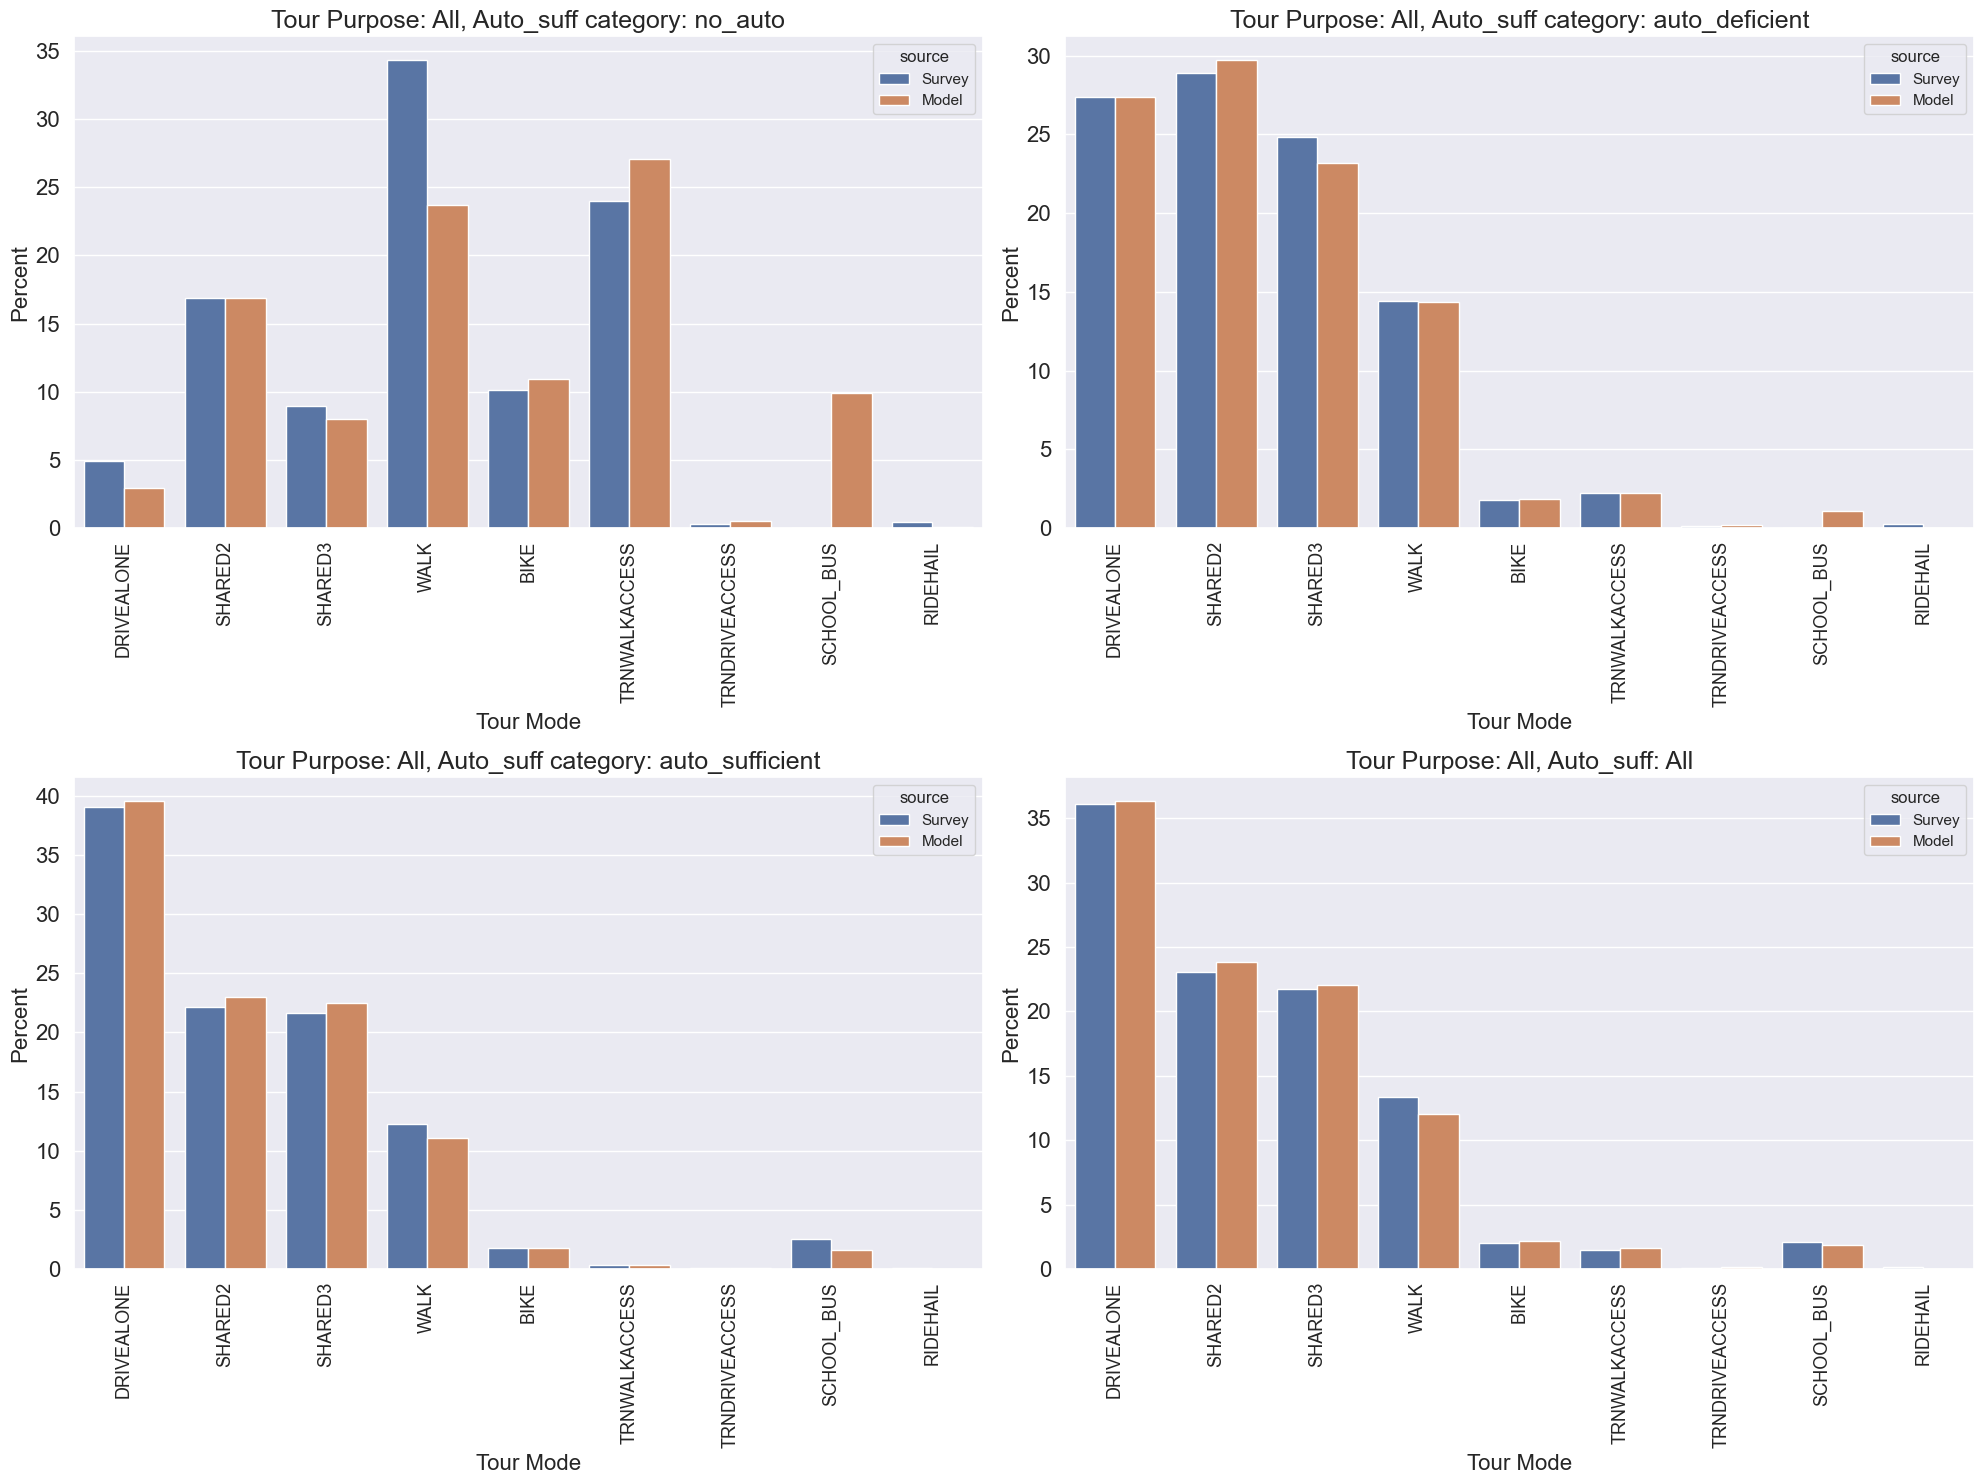

Coefficient Statistics: 
	 365 total coefficients
	 11 constrained coefficients
	 248 coefficients adjusted
	 235 coefficients converged
	 130 coefficients not converged


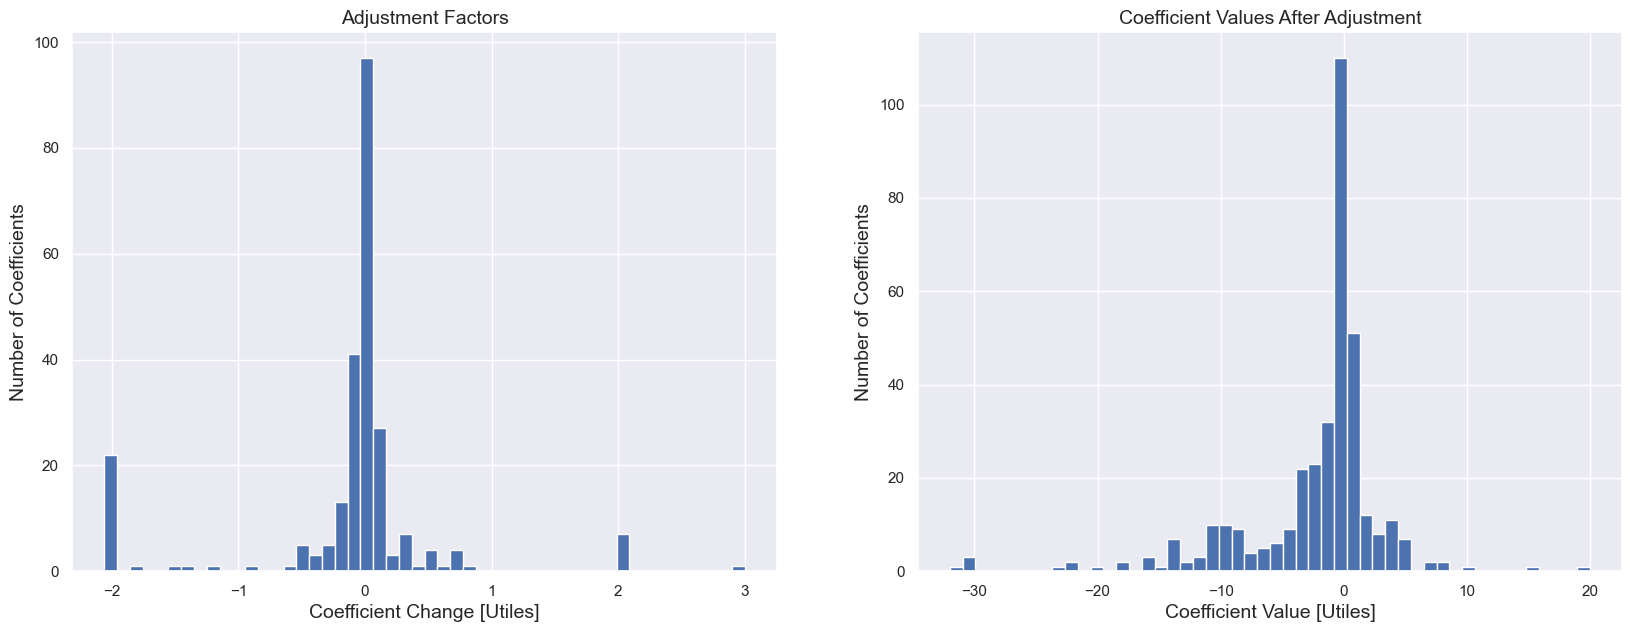

Top 10 largest coefficients:


,coefficient_name,value,model_counts,target_counts,coef_change,new_value,converged
147,sr2_ASC_no_auto_univ,-30.000000,15.0,0.0,-2,-32.000000,True
277,rideshare_ASC_no_auto_univ,-28.000000,21.0,0.0,-2,-30.000000,True
176,sr3p_ASC_no_auto_univ,-28.000000,52.0,0.0,-2,-30.000000,True
116,sov_ASC_no_auto_univ,-28.000000,41.0,0.0,-2,-30.000000,True
353,joint_rideshare_ASC_no_auto_joint_maint,-21.373745,10.0,0.0,-2,-23.373745,True
297,joint_bike_ASC_auto_deficient_joint_maint,-22.000000,0.0,0.0,<NA>,-22.000000,True
357,joint_rideshare_ASC_auto_deficient_joint_maint,-22.000000,0.0,0.0,<NA>,-22.000000,True
317,joint_sr3p_ASC_no_auto_joint_maint,-18.412494,108.0,0.0,-2,-20.412494,False
23,coef_topology_bike_multiplier_eatout_escort_ot...,20.000000,NaN,NaN,<NA>,20.000000,True
280,rideshare_ASC_no_auto_work,-18.000000,0.0,0.0,<NA>,-18.000000,True


In [9]:
_ = perform_tour_mode_choice_model_calibration(
    asim_output_dir=output_dir, # folder containing the activitysim model output
    asim_configs_dir=configs_dir,  # folder containing activitysim tour mode choice config files
    tour_mode_choice_calib_targets_file_autosuff = tour_mode_choice_calib_targets_file_autosuff, #edited
    tour_mode_choice_calib_targets_file_income = tour_mode_choice_calib_targets_file_income,  # folder containing tour mode choice calibration tables
    max_ASC_adjust=max_ASC_adjust,  
    damping_factor=damping_factor,  # constant multiplied to all adjustments
    adjust_when_zero_counts=adjust_when_zero_counts,
    output_dir=output_dir,  # location to write model calibration steps
    )


## Initial Model Run

In [1]:
if want_to_do_initial_model_run:
    run_activitysim(
        data_dir=data_dir,  # data inputs for ActivitySim
        configs_dir=configs_dir,  # these files are copied to the config section of the run directory
        run_dir=activitysim_run_dir,  # ActivitySim run directory
        output_dir=output_dir,  # location to store run model outputs
        settings_file=cold_start_settings_mp_file,  # optional: ActivitySim settings.yaml to replace the one in configs_dir
        tour_mc_coef_file=tour_mc_coef_file,  # optional: tour_mode_choice_coeffs.csv to replace the one in configs_dir
        configs_mp_dir=configs_mp_dir  # optional: location of config files for multiprocessing
    )
    
    print('asim run done')
    
    _ = perform_tour_mode_choice_model_calibration(
        asim_output_dir=output_dir, # folder containing the activitysim model output
        asim_configs_dir=configs_dir,  # folder containing activitysim tour mode choice config files
        tour_mode_choice_calib_targets_file_autosuff = tour_mode_choice_calib_targets_file_autosuff, #edited
        tour_mode_choice_calib_targets_file_income = tour_mode_choice_calib_targets_file_income,  # folder containing tour mode choice calibration tables
        max_ASC_adjust=max_ASC_adjust,  
        damping_factor=damping_factor,  # constant multiplied to all adjustments
        adjust_when_zero_counts=adjust_when_zero_counts,
        output_dir=output_dir,  # location to write model calibration steps
    )
    tour_mc_coef_file = os.path.join(output_dir, 'tour_mode_choice_coeffs.csv') 
else:
    print("No initial model run performed.")




NameError: name 'want_to_do_initial_model_run' is not defined

## Iterating

C:\RSG_test\semcog\Tasks\Tour_mc_calib\asim_run_dir\configs_mp
ActivitySim run started at:  2022-02-18 11:49:35.958634
python simulation.py -c C:\RSG_test\semcog\Tasks\Tour_mc_calib\asim_run_dir\configs_mp -d C:\RSG_test\semcog\Model_Runs\SEMCOG_ABM_2.4\Input\Data -o C:\RSG_test\semcog\Tasks\Tour_mc_calib\asim_run_dir -c C:\RSG_test\semcog\Tasks\Tour_mc_calib\asim_run_dir\configs
ActivitySim ended at 2022-02-18 12:17:48.007416
Run Time:  1692.05 secs =  28.200833333333332  mins
Sample rate of  0.10300000000000001 results in  593406 out of 5761223 tours


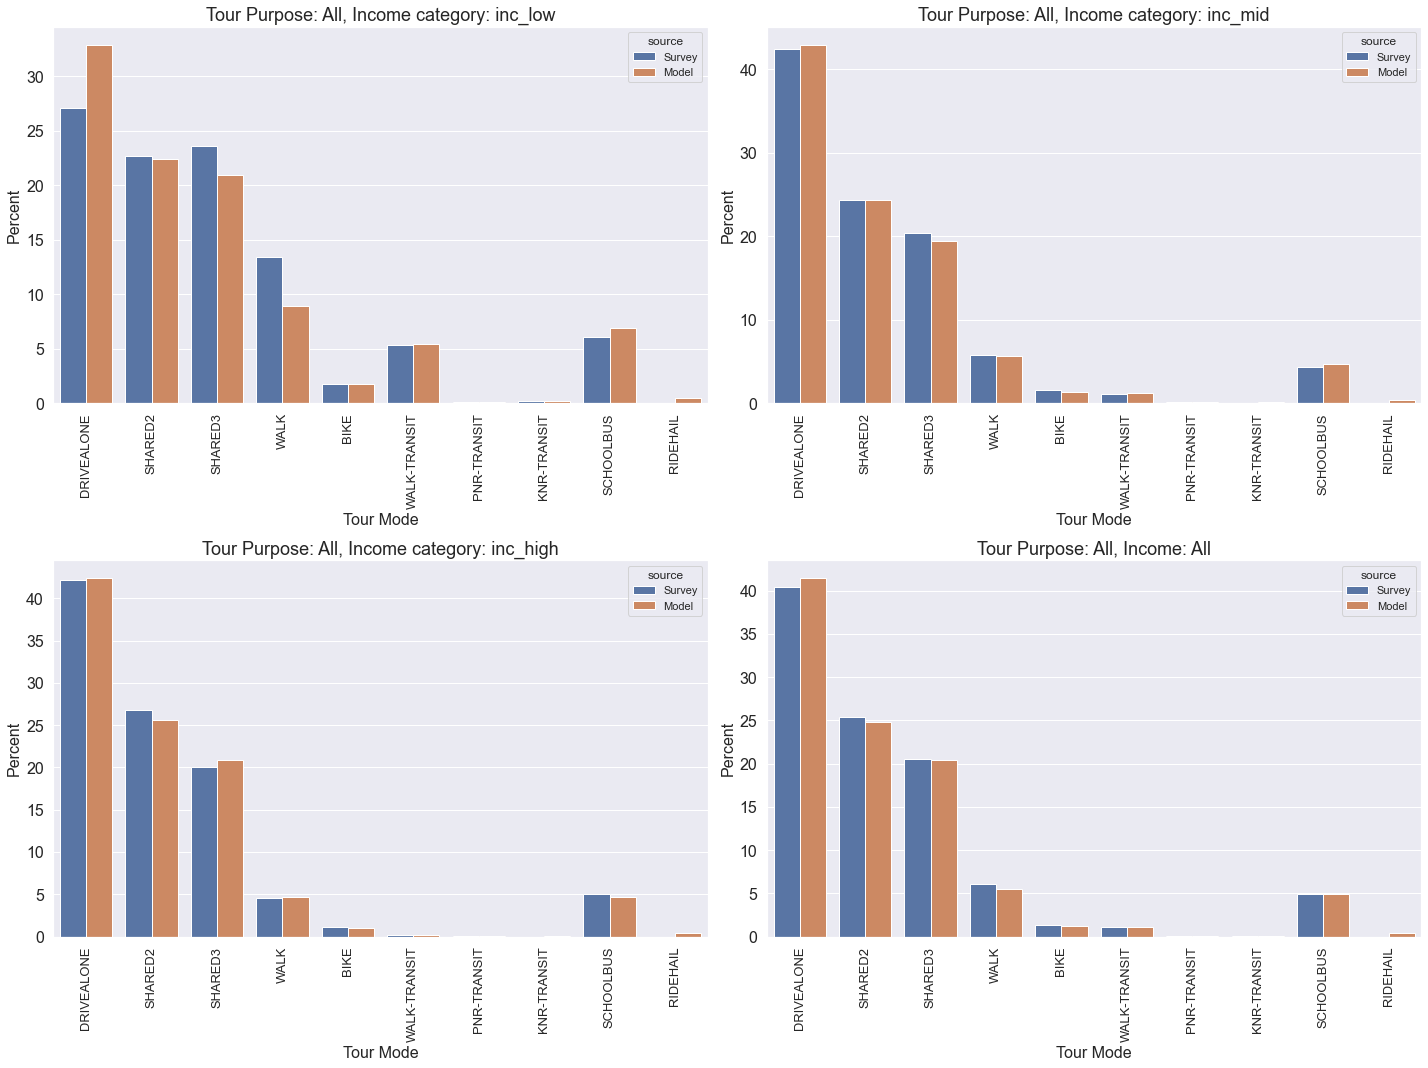

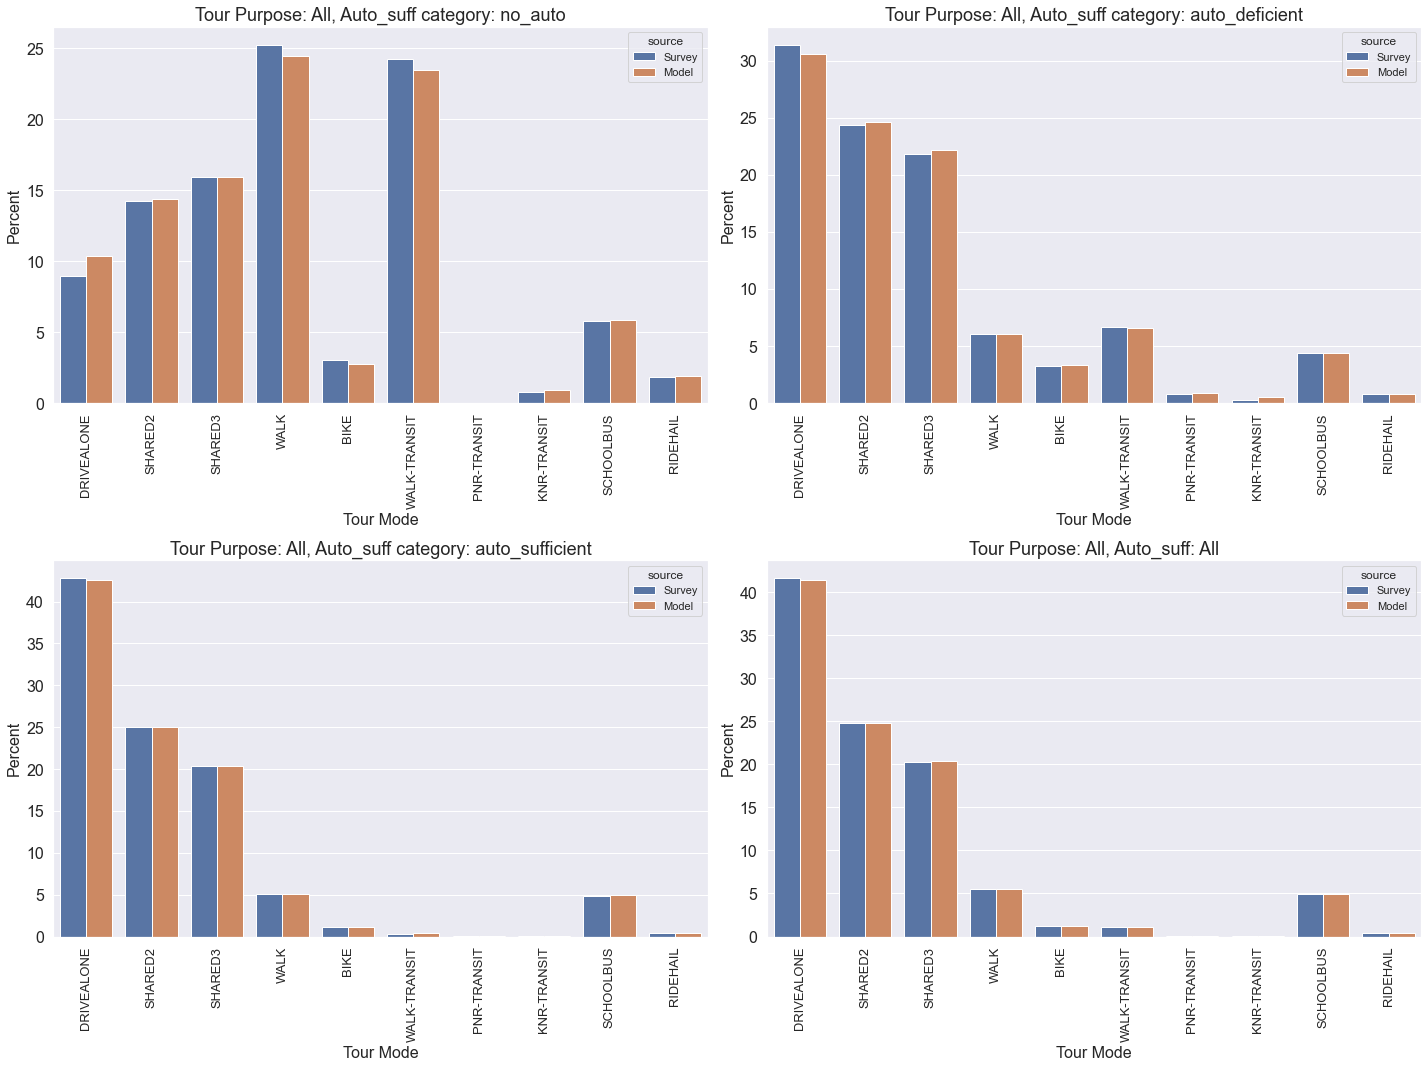

Coefficient Statistics: 
	 480 total coefficients
	 23 constrained coefficients
	 339 coefficients adjusted
	 449 coefficients converged
	 31 coefficients not converged


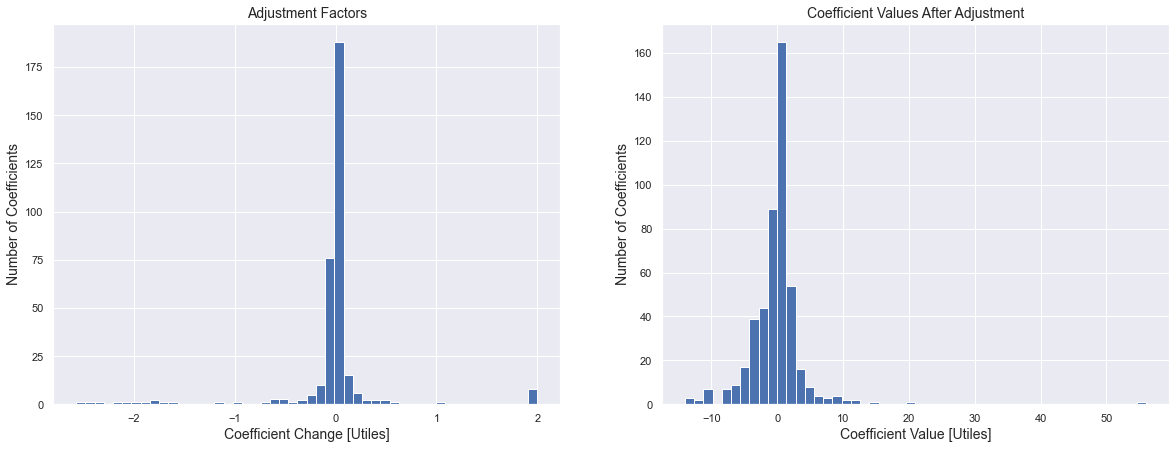

Top 10 largest coefficients:


,coefficient_name,value,model_counts,target_counts,coef_change,new_value,converged
430,pnr_transit_ASC_inc_mid_atwork,54.000000,0.0,4.0,2,56.000000,True
18,coef_topology_bike_multiplier_eatout_escort_ot...,20.000000,NaN,NaN,<NA>,20.000000,True
16,coef_topology_walk_multiplier_eatout_escort_ot...,15.000000,NaN,NaN,<NA>,15.000000,True
377,joint_tnc_single_ASC_auto_sufficient_all,-14.015900,NaN,NaN,<NA>,-14.015900,True
470,knr_transit_ASC_inc_high_atwork,-14.000000,0.0,0.0,<NA>,-14.000000,True
380,joint_tnc_shared_ASC_auto_sufficient_all,-13.205000,NaN,NaN,<NA>,-13.205000,True
38,walk_ASC_no_auto_school,12.235497,2981.0,2952.0,-0.00586554,12.229632,True
450,knr_transit_ASC_inc_low_atwork,-10.000000,10.0,0.0,-2,-12.000000,True
374,joint_taxi_ASC_auto_sufficient_all,-11.709900,NaN,NaN,<NA>,-11.709900,True
258,knr_transit_ASC_no_auto_school,10.999068,19.0,29.0,0.253714,11.252782,True


C:\RSG_test\semcog\Tasks\Tour_mc_calib\asim_run_dir\configs_mp
ActivitySim run started at:  2022-02-18 12:18:05.884573
python simulation.py -c C:\RSG_test\semcog\Tasks\Tour_mc_calib\asim_run_dir\configs_mp -d C:\RSG_test\semcog\Model_Runs\SEMCOG_ABM_2.4\Input\Data -o C:\RSG_test\semcog\Tasks\Tour_mc_calib\asim_run_dir -c C:\RSG_test\semcog\Tasks\Tour_mc_calib\asim_run_dir\configs
ActivitySim ended at 2022-02-18 12:47:26.980615
Run Time:  1761.1 secs =  29.351666666666667  mins
Sample rate of  0.10300000000000001 results in  593409 out of 5761252 tours


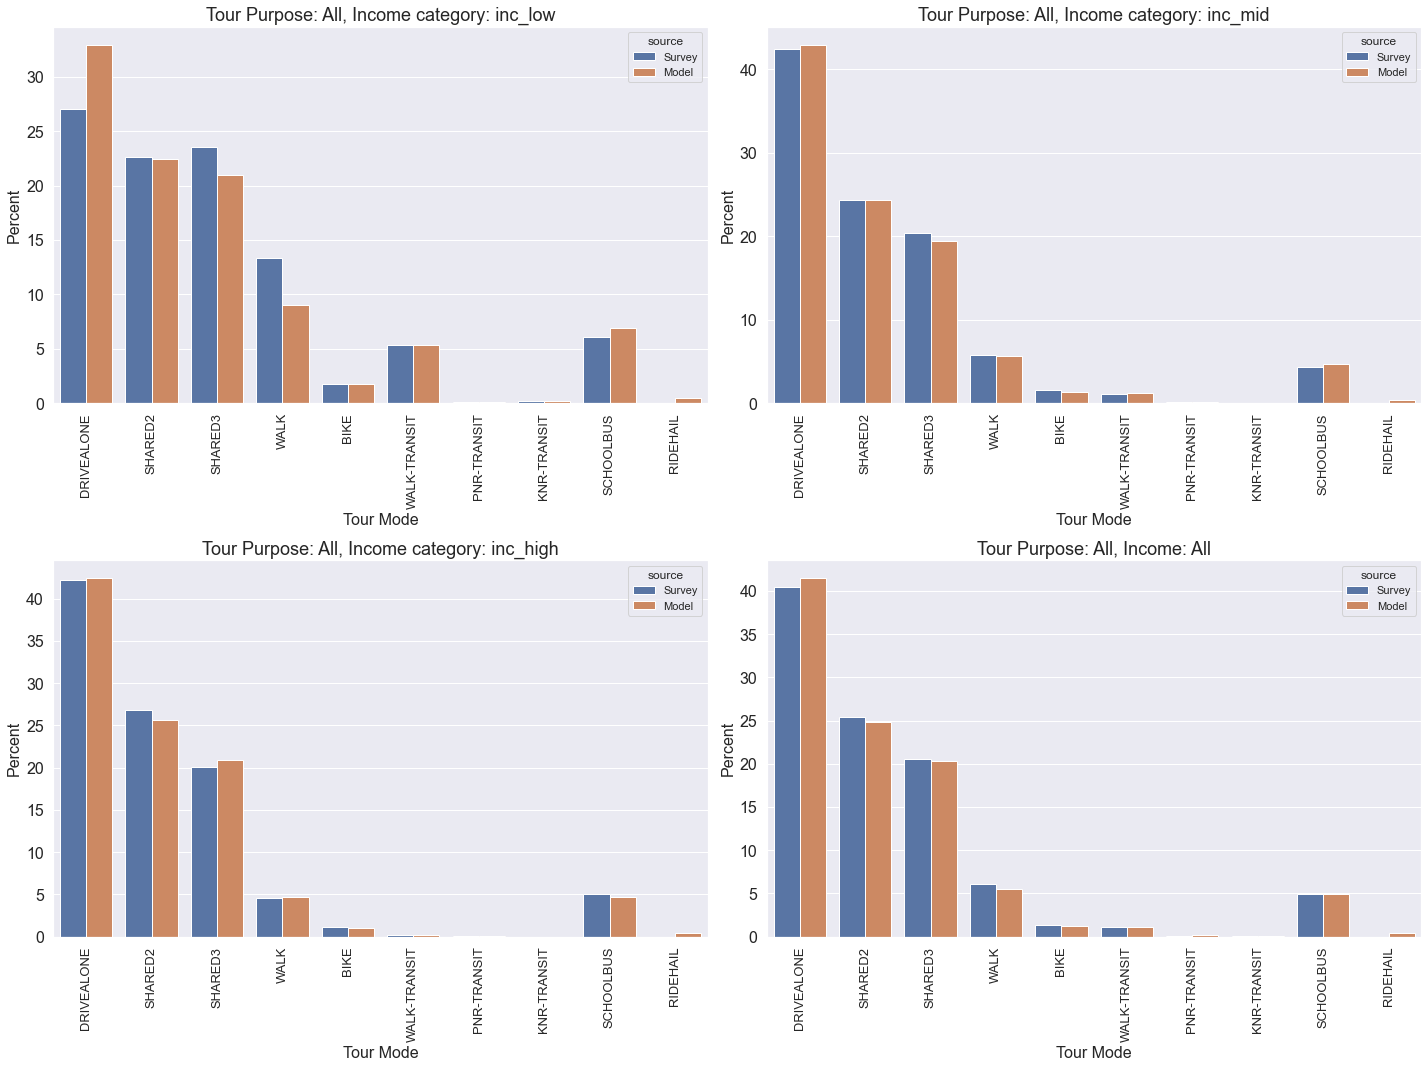

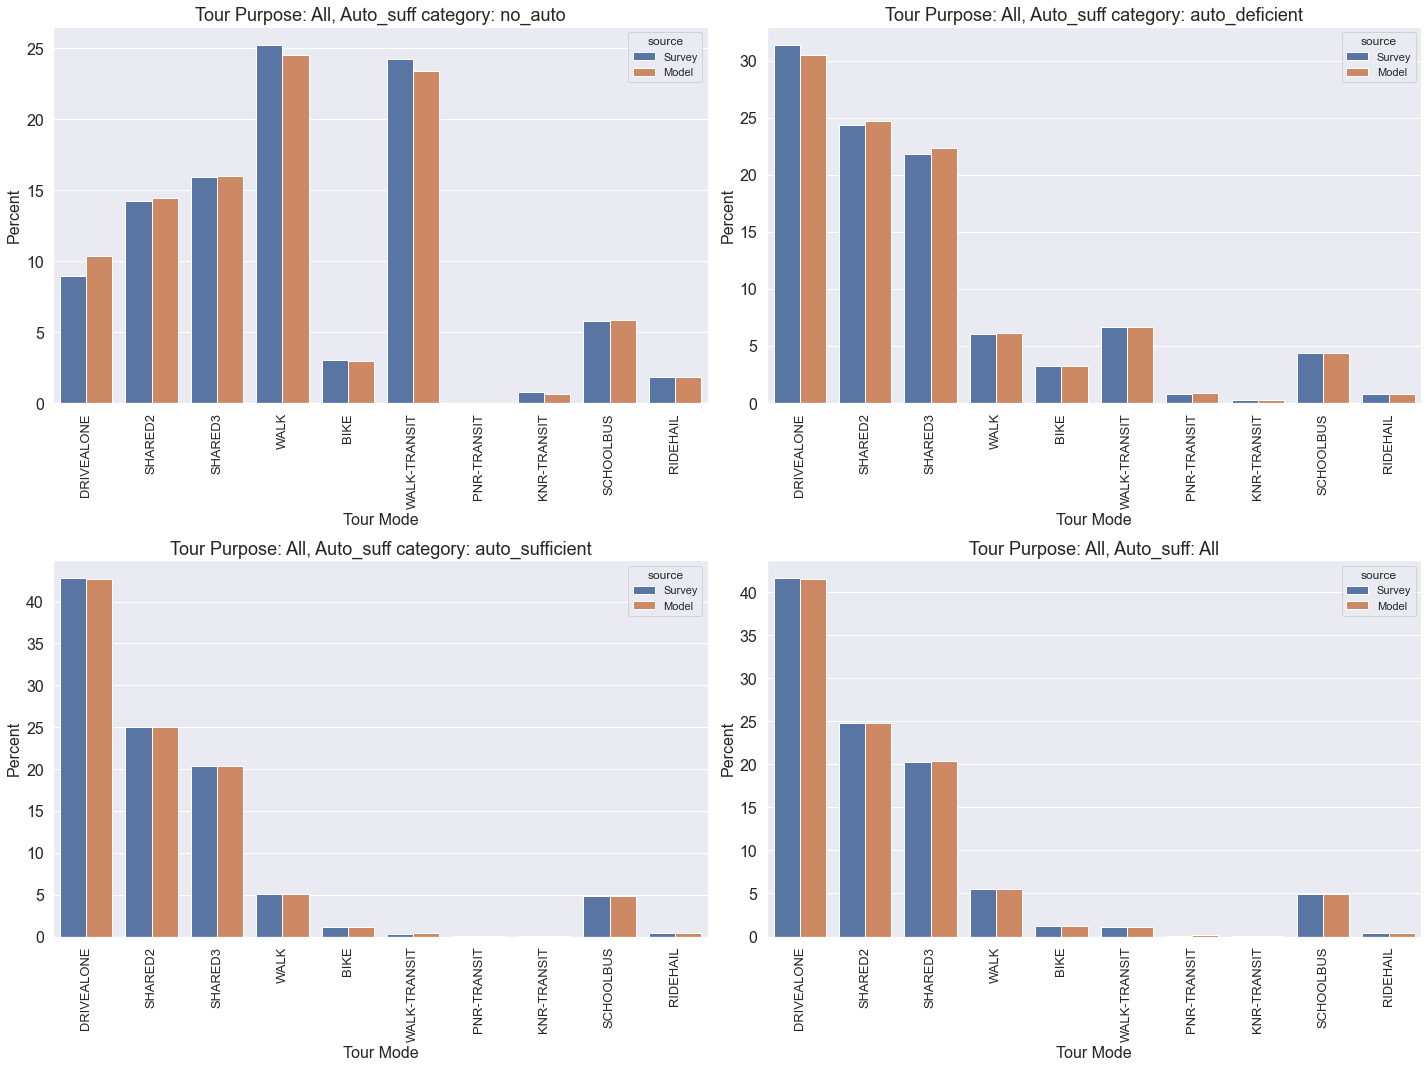

Coefficient Statistics: 
	 480 total coefficients
	 23 constrained coefficients
	 338 coefficients adjusted
	 456 coefficients converged
	 24 coefficients not converged


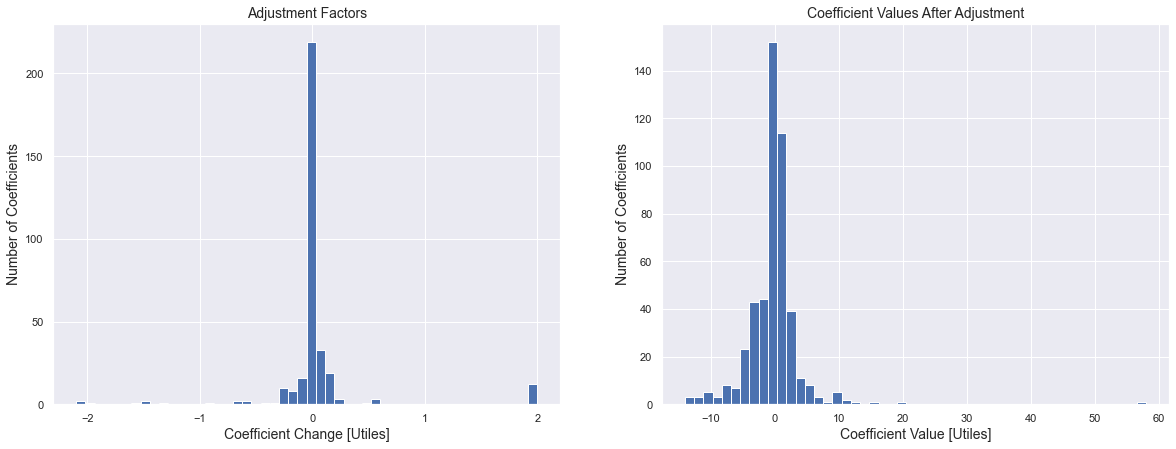

Top 10 largest coefficients:


,coefficient_name,value,model_counts,target_counts,coef_change,new_value,converged
430,pnr_transit_ASC_inc_mid_atwork,56.000000,0.0,4.0,2,58.000000,True
18,coef_topology_bike_multiplier_eatout_escort_ot...,20.000000,NaN,NaN,<NA>,20.000000,True
16,coef_topology_walk_multiplier_eatout_escort_ot...,15.000000,NaN,NaN,<NA>,15.000000,True
377,joint_tnc_single_ASC_auto_sufficient_all,-14.015900,NaN,NaN,<NA>,-14.015900,True
470,knr_transit_ASC_inc_high_atwork,-14.000000,0.0,0.0,<NA>,-14.000000,True
380,joint_tnc_shared_ASC_auto_sufficient_all,-13.205000,NaN,NaN,<NA>,-13.205000,True
38,walk_ASC_no_auto_school,12.229632,2961.0,2952.0,-0.00182649,12.227805,True
450,knr_transit_ASC_inc_low_atwork,-12.000000,0.0,0.0,<NA>,-12.000000,True
374,joint_taxi_ASC_auto_sufficient_all,-11.709900,NaN,NaN,<NA>,-11.709900,True
258,knr_transit_ASC_no_auto_school,11.252782,29.0,29.0,0,11.252782,True


C:\RSG_test\semcog\Tasks\Tour_mc_calib\asim_run_dir\configs_mp
ActivitySim run started at:  2022-02-18 12:47:44.739153
python simulation.py -c C:\RSG_test\semcog\Tasks\Tour_mc_calib\asim_run_dir\configs_mp -d C:\RSG_test\semcog\Model_Runs\SEMCOG_ABM_2.4\Input\Data -o C:\RSG_test\semcog\Tasks\Tour_mc_calib\asim_run_dir -c C:\RSG_test\semcog\Tasks\Tour_mc_calib\asim_run_dir\configs
ActivitySim ended at 2022-02-18 13:18:00.011073
Run Time:  1815.27 secs =  30.2545  mins
Sample rate of  0.10300000000000001 results in  593408 out of 5761242 tours


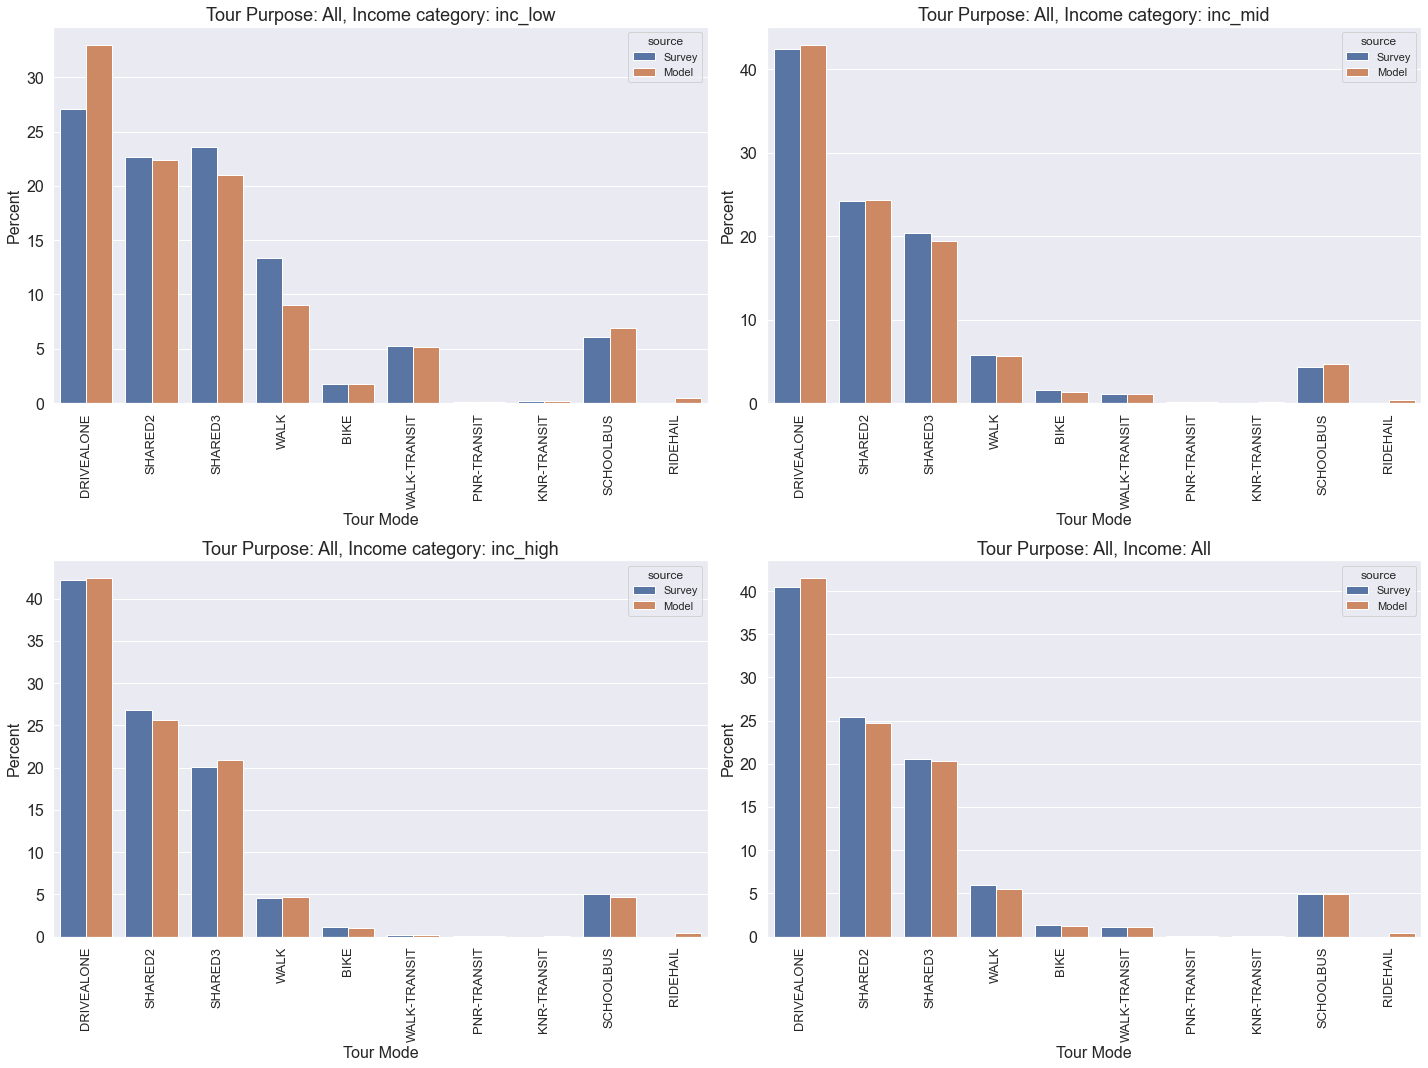

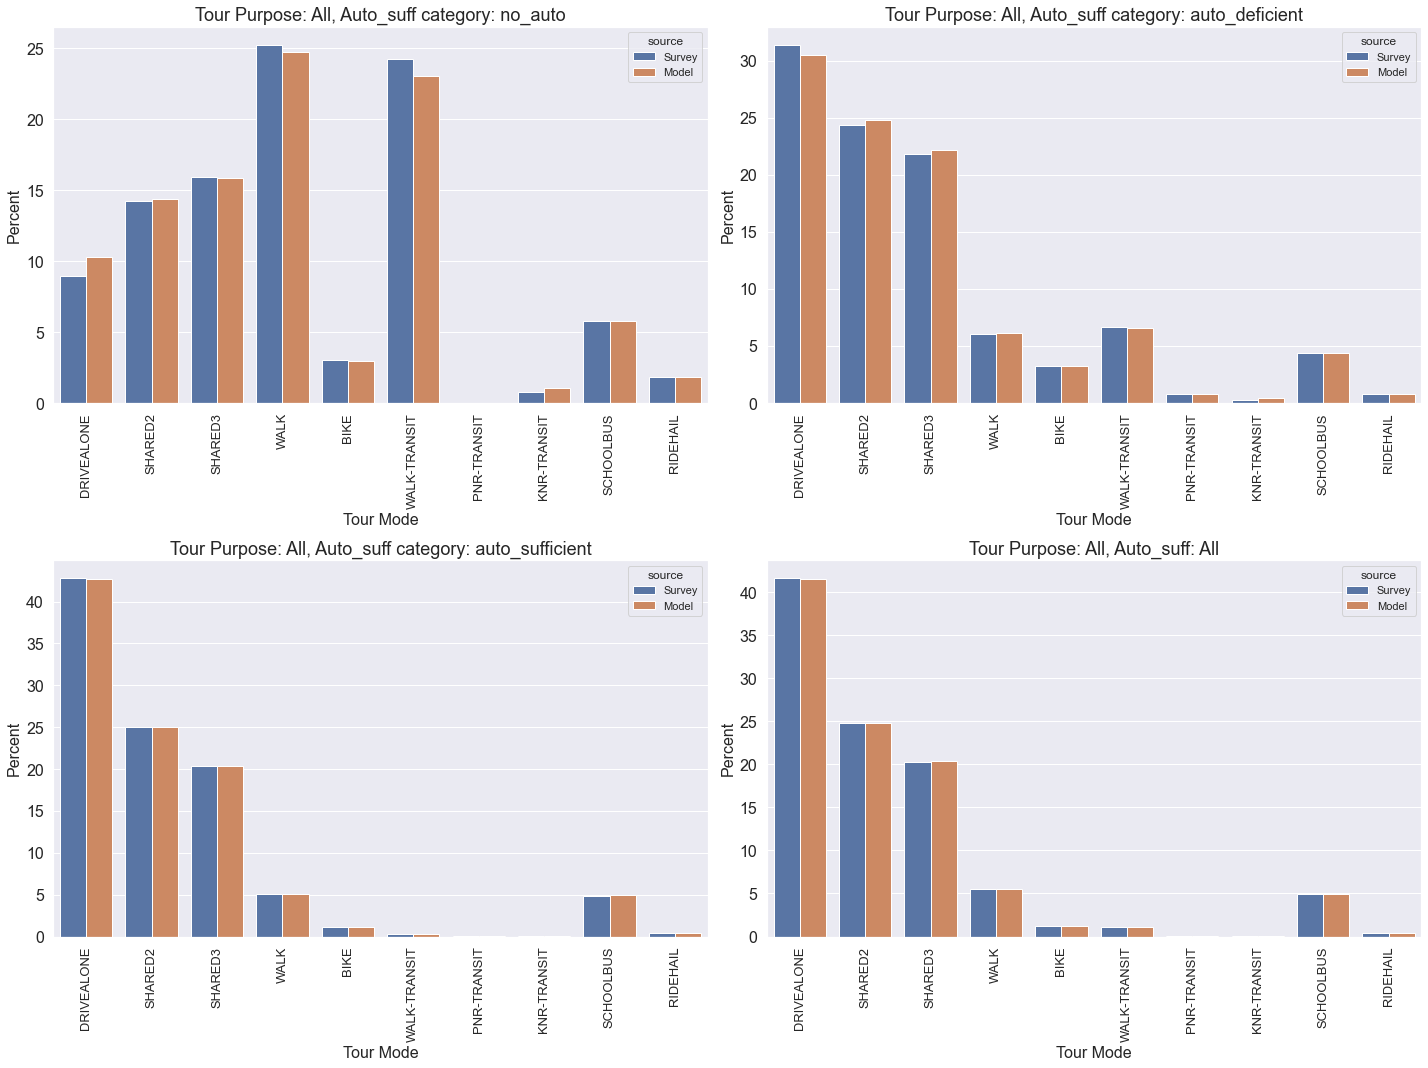

Coefficient Statistics: 
	 480 total coefficients
	 23 constrained coefficients
	 338 coefficients adjusted
	 448 coefficients converged
	 32 coefficients not converged


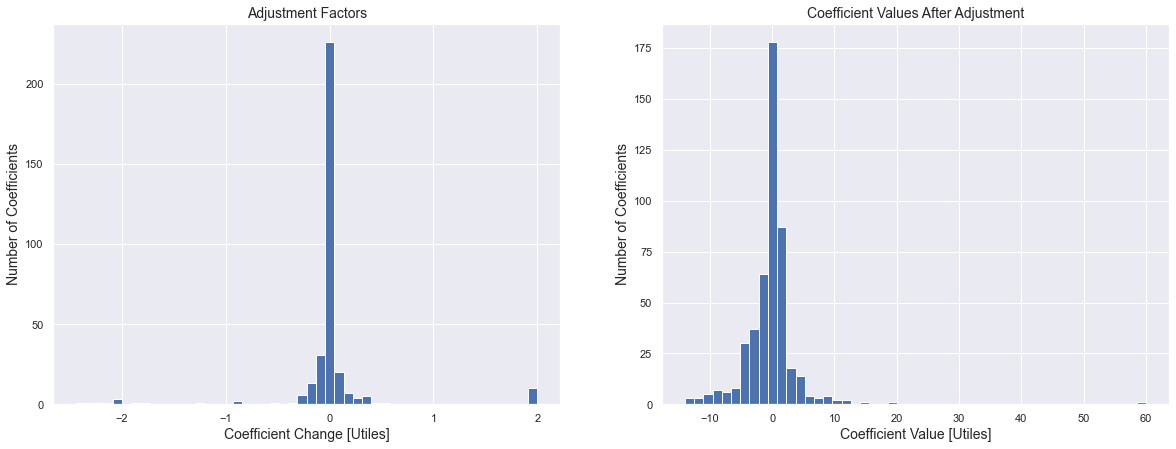

Top 10 largest coefficients:


,coefficient_name,value,model_counts,target_counts,coef_change,new_value,converged
430,pnr_transit_ASC_inc_mid_atwork,58.000000,0.0,4.0,2,60.000000,True
18,coef_topology_bike_multiplier_eatout_escort_ot...,20.000000,NaN,NaN,<NA>,20.000000,True
16,coef_topology_walk_multiplier_eatout_escort_ot...,15.000000,NaN,NaN,<NA>,15.000000,True
377,joint_tnc_single_ASC_auto_sufficient_all,-14.015900,NaN,NaN,<NA>,-14.015900,True
470,knr_transit_ASC_inc_high_atwork,-14.000000,0.0,0.0,<NA>,-14.000000,True
380,joint_tnc_shared_ASC_auto_sufficient_all,-13.205000,NaN,NaN,<NA>,-13.205000,True
38,walk_ASC_no_auto_school,12.227805,2961.0,2952.0,-0.00182649,12.225979,True
450,knr_transit_ASC_inc_low_atwork,-12.000000,0.0,0.0,<NA>,-12.000000,True
374,joint_taxi_ASC_auto_sufficient_all,-11.709900,NaN,NaN,<NA>,-11.709900,True
258,knr_transit_ASC_no_auto_school,11.252782,29.0,29.0,0,11.252782,True




 Final coefficient table written to:  C:\RSG_test\semcog\Tasks\Tour_mc_calib\Output_2\tour_mode_choice_coeffs.csv


In [5]:
iteration_output_dir = output_dir + '_0'
#calibration_iterations_to_run
for i in range(calibration_iterations_to_run):
    run_activitysim(
         data_dir=data_dir,  # data inputs for ActivitySim
         configs_dir=configs_dir,  # these files are copied to the config section of the run directory
         run_dir=activitysim_run_dir,  # ActivitySim run directory
         output_dir=iteration_output_dir,  # location to store run model outputs
         settings_file=warm_start_settings_mp_file,  # optional: ActivitySim settings.yaml to replace the one in configs_dir
         tour_mc_coef_file=tour_mc_coef_file,  # optional: tour_mode_choice_coeffs.csv to replace the one in configs_dir
         configs_mp_dir=configs_mp_dir  # optional: location of config files for multiprocessing
     )

    _ = perform_tour_mode_choice_model_calibration(
        asim_output_dir=iteration_output_dir, # folder containing the activitysim model output
        asim_configs_dir=os.path.join(activitysim_run_dir, 'configs'),  # folder containing tour mode choice config files
        tour_mode_choice_calib_targets_file_autosuff = tour_mode_choice_calib_targets_file_autosuff, #edited
        tour_mode_choice_calib_targets_file_income = tour_mode_choice_calib_targets_file_income, # folder containing tour mode choice calibration tables
        max_ASC_adjust=max_ASC_adjust,  # maximum allowed adjustment per iteration
        damping_factor=damping_factor,  # constant multiplied to all adjustments
        adjust_when_zero_counts=adjust_when_zero_counts,
        output_dir=iteration_output_dir,  # location to write model calibration steps
    )
    
    tour_mc_coef_file = os.path.join(iteration_output_dir, 'tour_mode_choice_coeffs.csv')
    iteration_output_dir = iteration_output_dir.strip('_'+str(i)) + '_' + str(i+1)

print("\n\n", "Final coefficient table written to: ", tour_mc_coef_file)